# SETUP

## Check environment

In [1]:
USE_GPU = False

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd
import joblib

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
%matplotlib widget

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction, inferenceLSTM
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData
from src.data_utils import mice

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1761052036.008537 2591197 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761052036.021461 2591197 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761052036.050459 2591197 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761052036.050478 2591197 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761052036.050481 2591197 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761052036.050484 2591197 computation_placer.cc:177] computation placer already registered. Please check linka

Using CPU to train
2.19.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data
conf

{'dataset': {'aod2022': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx',
   'target_start_date': '2022-01-01',
   'target_end_date': '2022-12-31'},
  'aod2021': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2021-12-31'},
  'mpair': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2022-12-31',
   'station_2022_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv',
   'station_2018_2021_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.csv',
   'merged_data_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/mpair_merged.csv',
   'merged_data_dir_all_locatio

# CMAQ DATA

## Load cmaq data

### Raw data

In [4]:
df_cmaq_raw = pd.read_csv(conf["dataset"]["cmaq_with_no"]["file_dir"])
df_cmaq_raw

,Datetime,PM25,PM10,O3,SO2,NO2,Station,NO
0,2022-01-01 07:00:00,4.878905,14.811759,0.097426,0.000165,0.002692,212,NaN
1,2022-01-01 08:00:00,6.771205,21.716939,0.076096,0.000226,0.003342,212,NaN
2,2022-01-01 09:00:00,7.170122,23.216116,0.066343,0.000253,0.002588,212,NaN
3,2022-01-01 10:00:00,7.128181,23.774334,0.056412,0.000227,0.001720,212,NaN
4,2022-01-01 11:00:00,6.519380,21.588541,0.048995,0.000167,0.001217,212,NaN
...,...,...,...,...,...,...,...,...
52327,2022-12-31 01:00:00,16.292831,54.826836,0.026622,0.000073,0.003449,214,0.000014
52328,2022-12-31 02:00:00,16.437155,55.074300,0.026347,0.000073,0.003513,214,0.000014
52329,2022-12-31 03:00:00,16.222981,55.691070,0.026656,0.000075,0.003364,214,0.000014
52330,2022-12-31 04:00:00,15.969438,54.991848,0.026848,0.000078,0.003203,214,0.000014


### Handle metadata

In [5]:
# Set datetime
df_cmaq_raw = df_cmaq_raw.assign(Datetime=pd.to_datetime(df_cmaq_raw["Datetime"]))

# Rename columns
df_cmaq_raw = df_cmaq_raw.rename(columns={name: f"{name.lower()}" for name in df_cmaq_raw.columns})

# Set index
df_cmaq_raw = df_cmaq_raw.set_index("datetime")

# Print
df_cmaq_raw

,pm25,pm10,o3,so2,no2,station,no
datetime,,,,,,,
2022-01-01 07:00:00,4.878905,14.811759,0.097426,0.000165,0.002692,212,NaN
2022-01-01 08:00:00,6.771205,21.716939,0.076096,0.000226,0.003342,212,NaN
2022-01-01 09:00:00,7.170122,23.216116,0.066343,0.000253,0.002588,212,NaN
2022-01-01 10:00:00,7.128181,23.774334,0.056412,0.000227,0.001720,212,NaN
2022-01-01 11:00:00,6.519380,21.588541,0.048995,0.000167,0.001217,212,NaN
...,...,...,...,...,...,...,...
2022-12-31 01:00:00,16.292831,54.826836,0.026622,0.000073,0.003449,214,0.000014
2022-12-31 02:00:00,16.437155,55.074300,0.026347,0.000073,0.003513,214,0.000014
2022-12-31 03:00:00,16.222981,55.691070,0.026656,0.000075,0.003364,214,0.000014


In [49]:
test = df_cmaq_raw.iloc[10000:10168].drop(columns=["station"]).fillna(-1).reset_index(drop=True)
result = {col: [] for col in test.columns}
for index, rows in test.iterrows():
    for col in test.columns:
        result[col].append(rows[col])

[np.float64(55.751547), np.float64(54.234552), np.float64(41.21475), np.float64(25.353162), np.float64(22.5887748), np.float64(19.910346), np.float64(20.1834168), np.float64(21.826164), np.float64(21.0208782), np.float64(18.6288672), np.float64(17.4721755), np.float64(18.5708412), np.float64(20.174238), np.float64(23.3686881), np.float64(17.4427098), np.float64(11.5738362), np.float64(12.625572), np.float64(13.3694958), np.float64(14.740944), np.float64(16.9163145), np.float64(19.472253), np.float64(22.889223), np.float64(23.553132), np.float64(24.958689), np.float64(31.117491), np.float64(25.3119765), np.float64(17.7477351), np.float64(13.8840879), np.float64(12.2629809), np.float64(11.44407), np.float64(11.1531867), np.float64(13.640763), np.float64(18.4390539), np.float64(17.9958831), np.float64(17.9259438), np.float64(18.869169), np.float64(23.1582342), np.float64(28.784106), np.float64(26.327196), np.float64(20.3923329), np.float64(19.842594), np.float64(24.594522), np.float64(24.

In [58]:
import json
with open('test.json', 'w') as fp:
    json.dump(result, fp)

## EDA

### Statistic

In [6]:
df_cmaq_stat = df_cmaq_raw.drop(columns=["station"]).describe()
df_cmaq_stat

,pm25,pm10,o3,so2,no2,no
count,52332.000000,52332.000000,52332.000000,5.233200e+04,52332.000000,4.469500e+04
mean,19.373324,55.656308,0.028526,5.530125e-04,0.005339,1.505774e-04
std,16.917802,47.628885,0.007503,9.868932e-04,0.006821,1.653540e-04
min,0.068628,0.089172,0.014453,3.160000e-09,0.000017,6.477872e-08
25%,9.758437,28.219765,0.025730,1.004007e-04,0.000934,3.696420e-05
50%,13.706406,44.558864,0.027195,2.344415e-04,0.002718,9.456088e-05
75%,23.379823,65.914449,0.028940,5.746160e-04,0.007005,2.093186e-04
max,294.028215,920.479352,0.119494,1.995822e-02,0.073905,1.297282e-03


### Check null

In [7]:
df_cmaq_raw.isnull().sum()

pm25          0
pm10          0
o3            0
so2           0
no2           0
station       0
no         7637
dtype: int64

### Correlation matrix

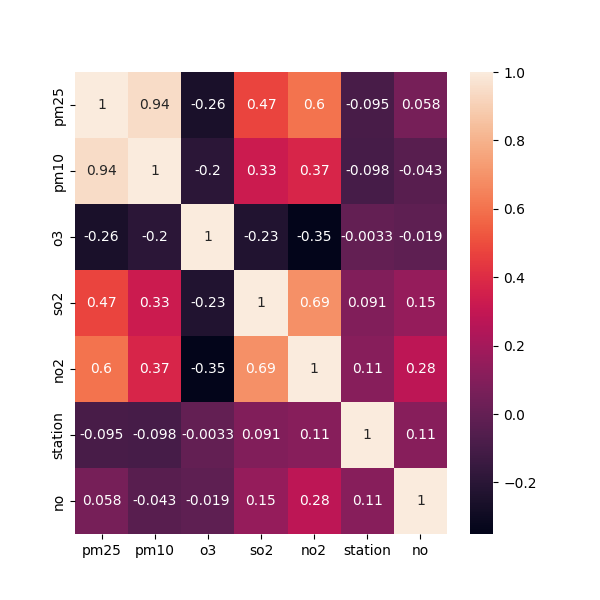

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(df_cmaq_raw.corr(), annot=True, ax=ax)
plt.show()

### Statistic by station

In [9]:
stations = sorted(df_cmaq_raw["station"].unique())
for station in stations:
    df_current_station = df_cmaq_raw[df_cmaq_raw["station"] == station]
    print(f"CURRENT STATION = {station}, RECORDS = {len(df_current_station)}")
    print(f"Missing NO: {df_current_station['no'].isnull().sum()}")

CURRENT STATION = 201, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 211, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 212, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 213, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 214, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 215, RECORDS = 7476
Missing NO: 1091
CURRENT STATION = 216, RECORDS = 7476
Missing NO: 1091


## Preprocessing

### Fill "NO" column


Handling for station 201



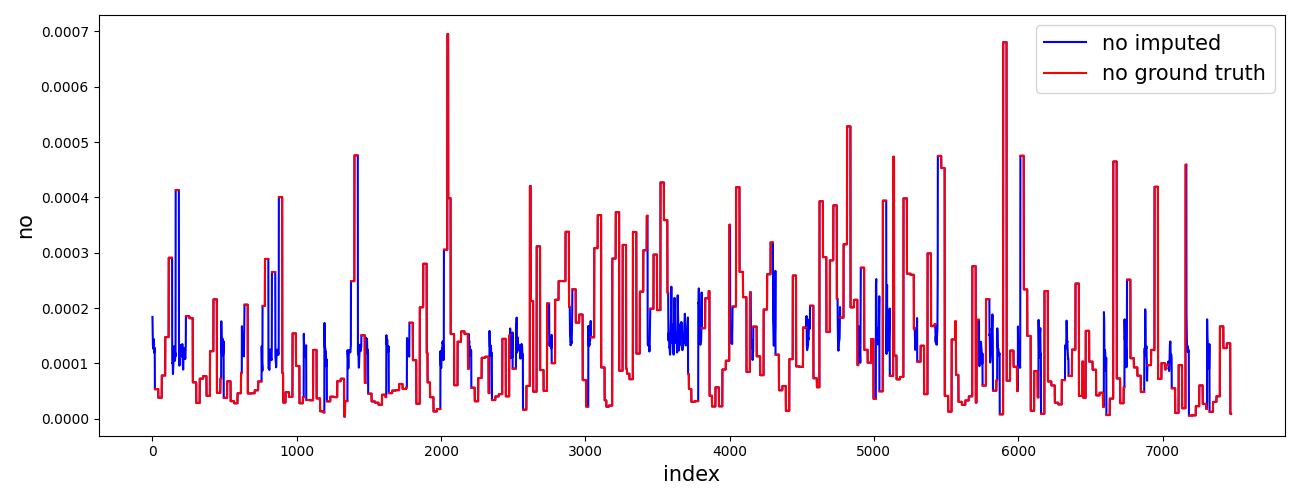


Handling for station 211



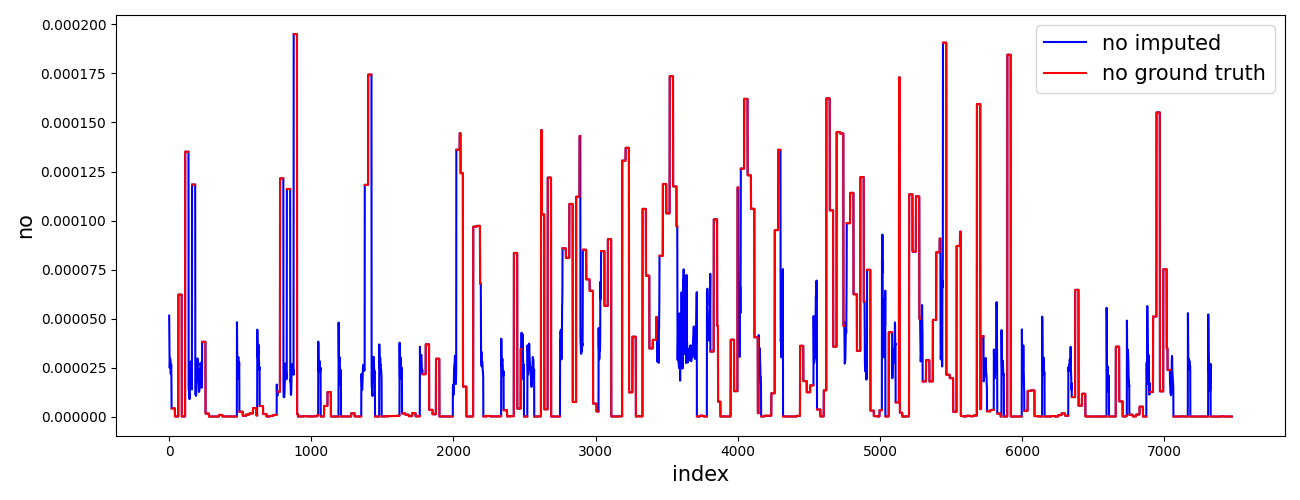


Handling for station 212



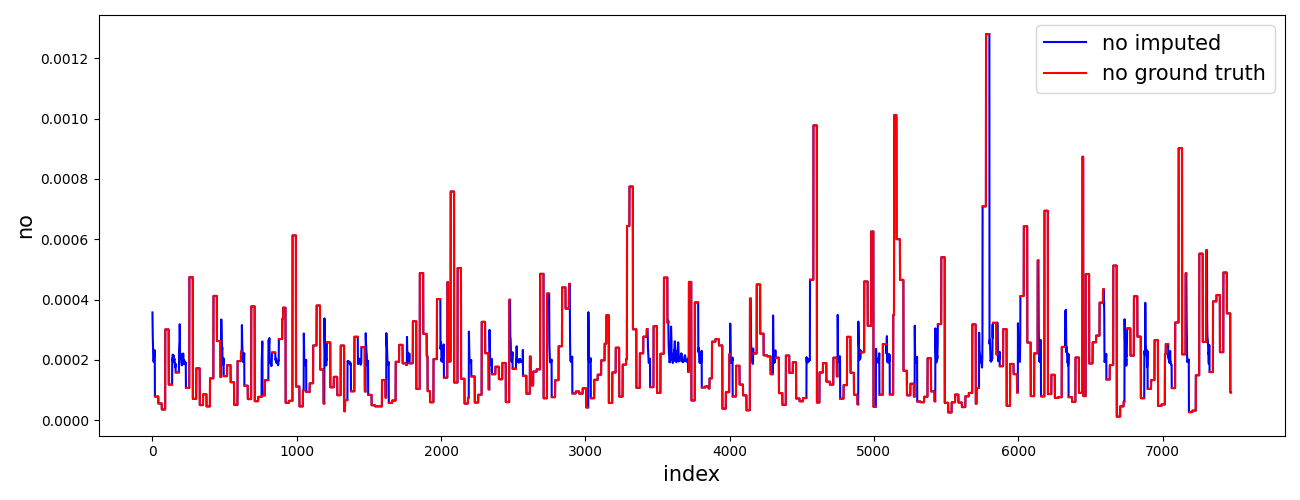


Handling for station 213



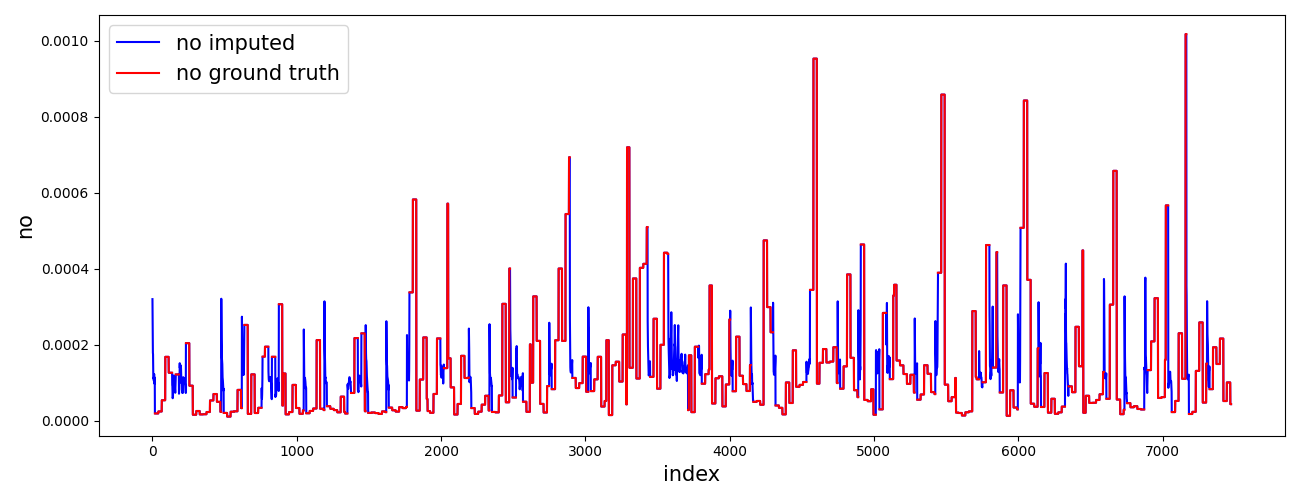


Handling for station 214



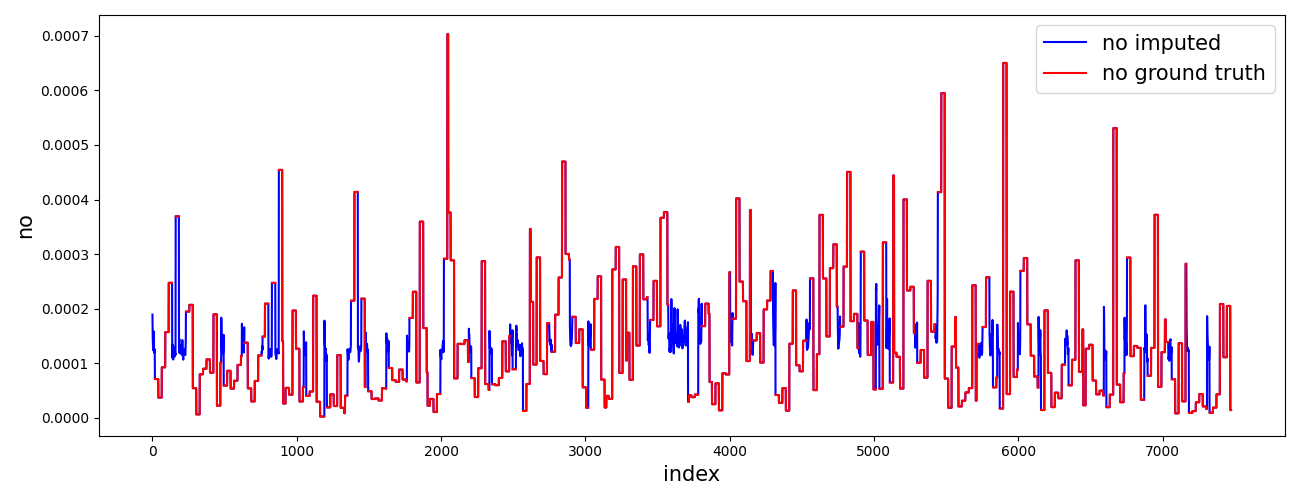


Handling for station 215



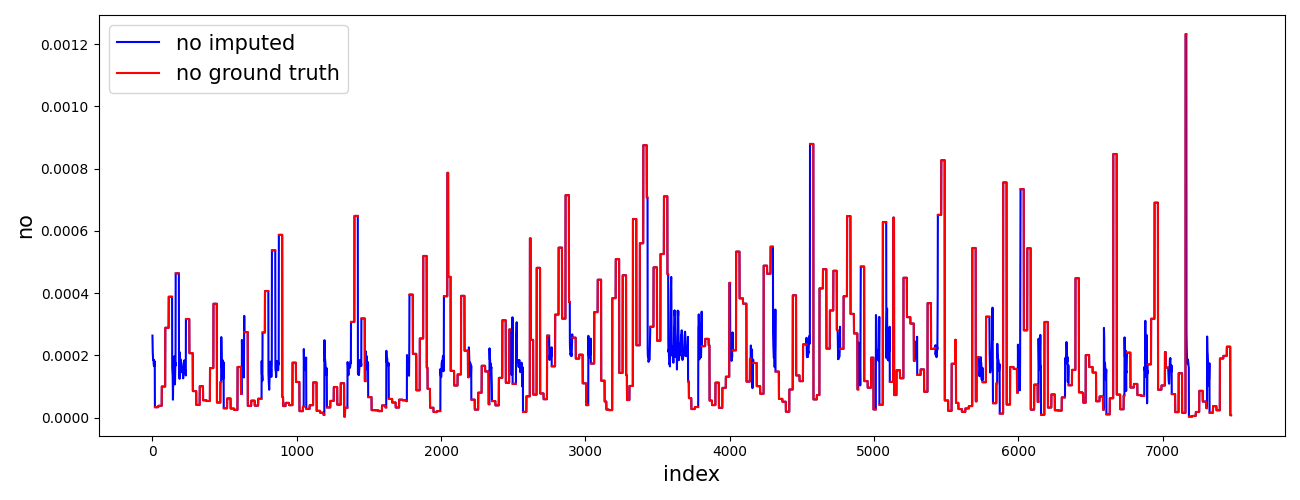


Handling for station 216



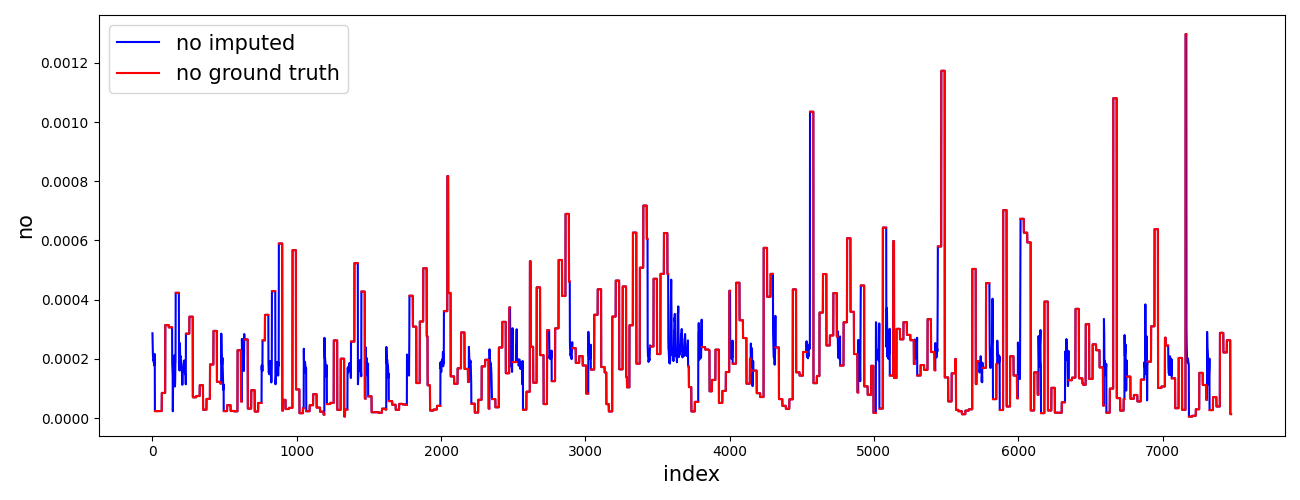

,pm25,pm10,o3,so2,no2,station,no
datetime,,,,,,,
2022-01-01 07:00:00,8.070718,28.069728,0.098301,0.000047,0.001115,201,0.000184
2022-01-01 08:00:00,9.922100,35.973360,0.078072,0.000062,0.001141,201,0.000162
2022-01-01 09:00:00,11.191617,40.858557,0.061198,0.000082,0.000941,201,0.000145
2022-01-01 10:00:00,11.655973,43.331055,0.050983,0.000087,0.000761,201,0.000134
2022-01-01 11:00:00,11.074831,39.380184,0.042117,0.000068,0.000600,201,0.000131
...,...,...,...,...,...,...,...
2022-12-31 01:00:00,9.481827,34.121409,0.026421,0.000149,0.002276,216,0.000013
2022-12-31 02:00:00,9.389163,34.542116,0.026171,0.000148,0.002208,216,0.000013
2022-12-31 03:00:00,9.472814,34.649932,0.026087,0.000151,0.002249,216,0.000013


In [10]:
all_stations_df = []

for station in sorted(df_cmaq_raw["station"].unique()):
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_cmaq_current_station = df_cmaq_raw[df_cmaq_raw["station"] == station]

    # Fill "aod" column
    df_cmaq_current_station_imputed = copy.deepcopy(df_cmaq_current_station)
    df_cmaq_current_station_imputed.loc[:, "no"] = mice(df_cmaq_current_station_imputed.drop(columns=["station"]))["no"]
    plot_2_data(data1=df_cmaq_current_station_imputed["no"],
               datalabel1="no imputed",
               data2=df_cmaq_current_station["no"],
               datalabel2="no ground truth",
               ylabel="no",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_cmaq_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_cmaq_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_cmaq_current_station_imputed)

# Merge all stations
df_cmaq = pd.concat(all_stations_df)
df_cmaq

### Extract datetime and station columns

In [11]:
# Get the time indices
cmaq_time_indices = df_cmaq.index
cmaq_time_indices

DatetimeIndex(['2022-01-01 07:00:00', '2022-01-01 08:00:00',
               '2022-01-01 09:00:00', '2022-01-01 10:00:00',
               '2022-01-01 11:00:00', '2022-01-01 12:00:00',
               '2022-01-01 13:00:00', '2022-01-01 14:00:00',
               '2022-01-01 15:00:00', '2022-01-01 16:00:00',
               ...
               '2022-12-30 20:00:00', '2022-12-30 21:00:00',
               '2022-12-30 22:00:00', '2022-12-30 23:00:00',
               '2022-12-31 00:00:00', '2022-12-31 01:00:00',
               '2022-12-31 02:00:00', '2022-12-31 03:00:00',
               '2022-12-31 04:00:00', '2022-12-31 05:00:00'],
              dtype='datetime64[ns]', name='datetime', length=52332, freq=None)

In [12]:
# Get the station column
cmaq_station_column = df_cmaq.loc[:, "station"]
cmaq_station_column

datetime
2022-01-01 07:00:00    201
2022-01-01 08:00:00    201
2022-01-01 09:00:00    201
2022-01-01 10:00:00    201
2022-01-01 11:00:00    201
                      ... 
2022-12-31 01:00:00    216
2022-12-31 02:00:00    216
2022-12-31 03:00:00    216
2022-12-31 04:00:00    216
2022-12-31 05:00:00    216
Name: station, Length: 52332, dtype: int64

### Split into features and labels
* Label: no
* Features: other columns

In [13]:
# Features with pm25_3km
cmaq_label = "no"
cmaq_feats = list(df_cmaq.columns)
cmaq_feats.remove(cmaq_label)
cmaq_feats.remove("station")

X_cmaq = df_cmaq.loc[:, cmaq_feats]
y_cmaq = df_cmaq.loc[:, [cmaq_label]]

In [14]:
X_cmaq

,pm25,pm10,o3,so2,no2
datetime,,,,,
2022-01-01 07:00:00,8.070718,28.069728,0.098301,0.000047,0.001115
2022-01-01 08:00:00,9.922100,35.973360,0.078072,0.000062,0.001141
2022-01-01 09:00:00,11.191617,40.858557,0.061198,0.000082,0.000941
2022-01-01 10:00:00,11.655973,43.331055,0.050983,0.000087,0.000761
2022-01-01 11:00:00,11.074831,39.380184,0.042117,0.000068,0.000600
...,...,...,...,...,...
2022-12-31 01:00:00,9.481827,34.121409,0.026421,0.000149,0.002276
2022-12-31 02:00:00,9.389163,34.542116,0.026171,0.000148,0.002208
2022-12-31 03:00:00,9.472814,34.649932,0.026087,0.000151,0.002249


In [15]:
y_cmaq

,no
datetime,
2022-01-01 07:00:00,0.000184
2022-01-01 08:00:00,0.000162
2022-01-01 09:00:00,0.000145
2022-01-01 10:00:00,0.000134
2022-01-01 11:00:00,0.000131
...,...
2022-12-31 01:00:00,0.000013
2022-12-31 02:00:00,0.000013
2022-12-31 03:00:00,0.000013


### Data normalization

In [16]:
# Scaled features
cmaq_features_scaler = MinMaxScaler()
X_cmaq_scaled = cmaq_features_scaler.fit_transform(X_cmaq)
X_cmaq_scaled = pd.DataFrame(X_cmaq_scaled, columns=X_cmaq.columns)
X_cmaq_scaled

,pm25,pm10,o3,so2,no2
0,0.027222,0.030401,0.798249,0.002360,0.014853
1,0.033520,0.038988,0.605661,0.003086,0.015207
2,0.037838,0.044296,0.445023,0.004108,0.012509
3,0.039418,0.046982,0.347769,0.004354,0.010063
4,0.037441,0.042690,0.263367,0.003422,0.007892
...,...,...,...,...,...
52327,0.032022,0.036976,0.113939,0.007443,0.030570
52328,0.031707,0.037433,0.111561,0.007392,0.029646
52329,0.031991,0.037550,0.110760,0.007548,0.030210
52330,0.034542,0.039138,0.113238,0.008329,0.036046


In [17]:
# Scaled label
cmaq_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_cmaq_scaled = cmaq_label_scaler.fit_transform(y_cmaq)
y_cmaq_scaled = pd.DataFrame(y_cmaq_scaled, columns=y_cmaq.columns)
y_cmaq_scaled

,no
0,0.141785
1,0.124603
2,0.111662
3,0.103283
4,0.101044
...,...
52327,0.010167
52328,0.010167
52329,0.010167
52330,0.010167


In [19]:
joblib.dump(cmaq_features_scaler, "cmaq_features_scaler.pkl")
joblib.dump(cmaq_label_scaler, "cmaq_label_scaler.pkl")

['cmaq_label_scaler.pkl']